In [1]:
!pip install torchvision torch

In [0]:
!pip install -q kaggle

In [3]:
from google.colab import files
f = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir ~/.kaggle

In [0]:
!chmod 600 kaggle.json

In [0]:
!cp kaggle.json ~/.kaggle

In [7]:
!kaggle competitions download -c Kannada-MNIST

  0% 0.00/818k [00:00<?, ?B/s]
100% 818k/818k [00:00<00:00, 52.8MB/s]
 52% 5.00M/9.71M [00:00<00:00, 31.2MB/s]
100% 9.71M/9.71M [00:00<00:00, 47.5MB/s]
  0% 0.00/1.90M [00:00<?, ?B/s]
100% 1.90M/1.90M [00:00<00:00, 263MB/s]
  0% 0.00/33.1k [00:00<?, ?B/s]
100% 33.1k/33.1k [00:00<00:00, 32.8MB/s]


In [8]:
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [0]:
import torch 
import torch.nn as nn 
from torch.autograd import Variable
import torch.utils.data as Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
dftrain = pd.read_csv('train.csv')
dftest = pd.read_csv('test.csv')

In [0]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=1, padding=2),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
        nn.Dropout(p=0.25)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
        nn.Dropout(p=0.25)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=2),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
        nn.Dropout(p=0.25)
    )
    self.fc = nn.Linear(256*3*3, 1024)
    self.batchNorm = nn.BatchNorm1d(1024)
    self.output = nn.Linear(1024,10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.size(0),-1)
    x = self.fc(x)
    x = self.batchNorm(x)
    out = self.output(x)
    return x, out

cnn = CNN().cuda()

In [28]:
cnn 

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
  )
  (fc): Linear(in_features=2304, out_features=1024, bias=True)
  (batchNorm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=1024, out_features=10, bias=True)
)

In [14]:
dftrain.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
Xtrain, ytrain = dftrain.iloc[:,1:].values.astype('float32'), dftrain.iloc[:,0].values.astype('float32')
Xtest = dftest.iloc[:,1:].values.astype('float32')

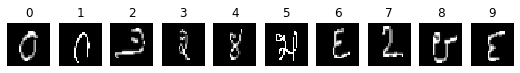

In [17]:
fig = plt.figure(figsize=(10,10))
for i in range(1,11):
  ax = fig.add_subplot(1,11,i)
  ax.set_title(int(ytrain[i-1]))
  ax.axis('off')
  plt.imshow(np.reshape(Xtrain[i-1,:],(28,28)), cmap='gray')
plt.show()

In [0]:
Xtrain = Xtrain / 255.
Xtest = Xtest / 255.
train_dataset = Data.TensorDataset(torch.Tensor(Xtrain),torch.Tensor(ytrain))
train_data = Data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_data = Data.DataLoader(torch.Tensor(Xtest),batch_size=256)


In [0]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

In [31]:
for i in range(500):
  for x,y in train_data:
    b_x = Variable(x.cuda()).float()
    b_y = Variable(y.cuda()).long()
    b_x = b_x.view(-1,1,28,28)
    output = cnn(b_x)[0]
    loss = loss_func(output, b_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
      predicted = torch.max(output, 1)[1].data.squeeze()
      accuracy = (predicted == b_y).sum().item()/ float(b_y.size(0))
      print('Epoch : {}, Loss: {:.9f}, Training Accuracy {:.5f}'.format(i, loss, accuracy*100.0))
    

Epoch : 0, Loss: 7.438315868, Training Accuracy 0.00000
Epoch : 0, Loss: 7.411390781, Training Accuracy 0.00000
Epoch : 0, Loss: 7.430870056, Training Accuracy 0.00000
Epoch : 0, Loss: 7.331441879, Training Accuracy 0.39062
Epoch : 0, Loss: 7.374427795, Training Accuracy 0.00000
Epoch : 0, Loss: 7.332338333, Training Accuracy 0.39062
Epoch : 0, Loss: 7.332551003, Training Accuracy 0.39062
Epoch : 0, Loss: 7.280588150, Training Accuracy 0.00000
Epoch : 0, Loss: 7.187486649, Training Accuracy 0.39062
Epoch : 0, Loss: 7.093070984, Training Accuracy 1.17188
Epoch : 0, Loss: 7.068336964, Training Accuracy 0.39062
Epoch : 0, Loss: 7.069885731, Training Accuracy 0.78125
Epoch : 0, Loss: 7.103170395, Training Accuracy 0.00000
Epoch : 0, Loss: 6.960156918, Training Accuracy 1.17188
Epoch : 0, Loss: 7.057902813, Training Accuracy 1.17188
Epoch : 0, Loss: 7.000174522, Training Accuracy 0.78125
Epoch : 0, Loss: 6.776149750, Training Accuracy 3.51562
Epoch : 0, Loss: 6.912575722, Training Accuracy 

In [37]:
testPred = []
for x in test_data:
  b_x = Variable(x)
  b_x = b_x.view(-1,1,28,28)
  output = cnn(b_x.cuda())[0]
  elems = torch.max(output,1)[1].data.squeeze()
  print(elems.tolist())
  testPred.extend(elems.tolist())

[3, 0, 2, 6, 7, 7, 1, 9, 3, 4, 8, 8, 1, 7, 8, 1, 5, 1, 5, 9, 3, 7, 6, 0, 2, 0, 8, 7, 0, 0, 8, 9, 2, 3, 2, 4, 6, 0, 7, 8, 3, 9, 4, 4, 5, 5, 7, 8, 7, 4, 3, 0, 9, 4, 5, 7, 1, 1, 6, 4, 7, 1, 2, 6, 1, 9, 1, 4, 9, 8, 4, 3, 7, 8, 4, 4, 1, 6, 1, 0, 3, 3, 4, 7, 3, 6, 3, 2, 2, 4, 2, 8, 7, 4, 7, 9, 7, 4, 7, 2, 5, 2, 7, 9, 3, 9, 5, 7, 3, 9, 7, 3, 4, 6, 6, 2, 1, 6, 0, 7, 7, 1, 5, 4, 5, 2, 1, 2, 6, 0, 3, 4, 1, 5, 9, 6, 8, 0, 6, 4, 0, 9, 3, 9, 8, 0, 8, 6, 5, 0, 8, 6, 6, 0, 8, 1, 7, 8, 2, 5, 0, 8, 1, 0, 5, 1, 2, 6, 2, 2, 8, 9, 9, 3, 2, 5, 7, 4, 0, 6, 1, 2, 8, 7, 3, 8, 7, 8, 1, 9, 5, 2, 7, 6, 8, 2, 6, 5, 9, 1, 9, 1, 3, 4, 4, 9, 7, 9, 0, 3, 0, 5, 1, 6, 2, 9, 0, 9, 0, 0, 5, 7, 4, 9, 4, 1, 2, 0, 3, 0, 3, 0, 9, 2, 0, 2, 6, 9, 4, 2, 4, 9, 9, 8, 5, 2, 2, 3, 7, 5, 3, 4, 0, 3, 7, 2]
[5, 5, 4, 6, 8, 4, 1, 4, 8, 6, 1, 5, 2, 6, 6, 2, 4, 8, 4, 9, 3, 1, 6, 1, 4, 0, 9, 9, 5, 4, 6, 3, 0, 9, 7, 1, 7, 7, 2, 7, 4, 0, 8, 0, 8, 3, 2, 3, 8, 9, 4, 3, 4, 1, 1, 3, 0, 3, 3, 8, 8, 2, 4, 7, 9, 4, 9, 4, 1, 7, 8, 2, 1, 7, 0, 7, 5,

In [0]:
submit = {'ImageId':[(i+1) for i in range(len(testPred))], 'Label':testPred}
submission = pd.DataFrame.from_dict(submit)
submission.to_csv('submission_kannada.csv',index=False)

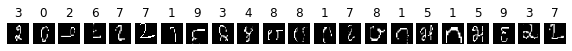

In [40]:
fig = plt.figure(figsize=(10,10))
for i in range(1,23):
  ax = fig.add_subplot(1,22,i)
  ax.set_title(testPred[i-1])
  ax.axis('off')
  plt.imshow(np.reshape(Xtest[i-1,:],(28,28)),cmap='gray')
plt.show()